In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import Tensor
import abc
from torch.distributions import MultivariateNormal, Poisson
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torch.nn import Module
from torch import nn
from torch.optim.lr_scheduler import StepLR
from main import *
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import pickle
from scipy.interpolate import CubicSpline
from sklearn.metrics import r2_score

torch.set_default_dtype(torch.float64)
import dill

In [2]:
data = pickle.load(open('data/Doherty_example.pickled', 'rb')) # load example data
binsize = 25 # binsize in ms
start = 0
data_len = 5000 # number of time bins to use for fitting
timepoints = np.arange(start, data_len+start) #subsample ~40 seconds of data so things will run somewhat quicker
print(data['Y'].shape)
fit_data = {'Y': data['Y'][..., timepoints], 'locs': data['locs'][timepoints, :], 'targets': data['targets'][timepoints, :], 'binsize': binsize}
# fit_data = {'Y': data['Y'], 'locs': data['locs'], 'targets': data['targets'], 'binsize': binsize}
Y = fit_data['Y'] # these are the actual recordings and is the input to our model
targets = fit_data['targets'] # these are the target locations
locs = fit_data['locs'] # these are the hand positions

# Y = Y[:, np.mean(Y,axis = (0, 2))/0.025 > 2, :] #subsample highly active neurons so things will run a bit quicker
Y = Y[:, np.mean(Y[..., :5000],axis = (0, 2))/0.025 > 2, :]

# Y_test = Y[..., 1000:] # hold out some data for testing
# Y = Y[..., :1000] # use first 1000 time bins for training
print(Y.shape)
ntrials, n, T = Y.shape # Y should have shape: [number of trials (here 1) x neurons x time points]

ts = np.arange(Y.shape[-1])*fit_data['binsize'] # measured in ms
cs = CubicSpline(ts, locs) # fit cubic spline to behavior
delay = 120
vels = cs(ts+delay, 1) # velocity (first derivative)
v = Tensor(vels.T[None, ...])
print(v.shape)

(1, 200, 70482)
(1, 194, 5000)
torch.Size([1, 2, 5000])


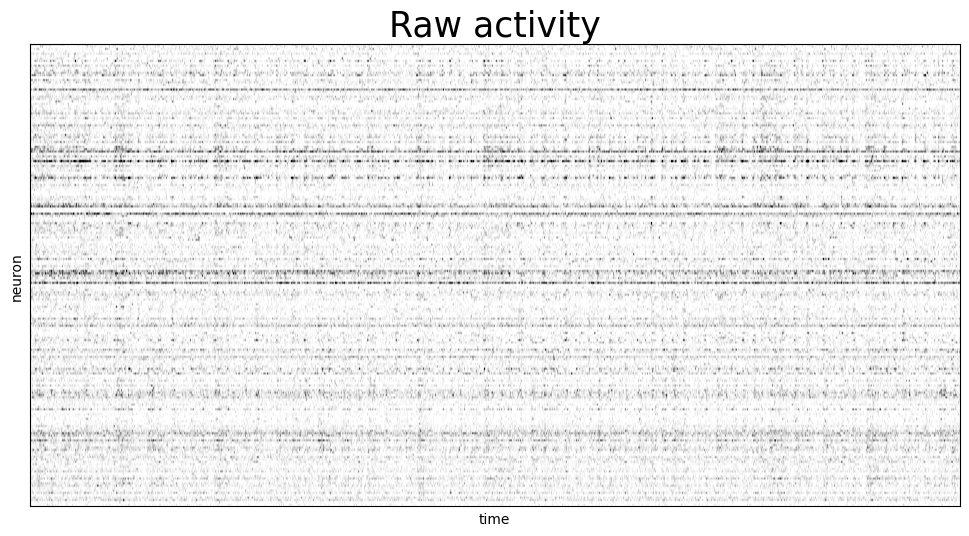

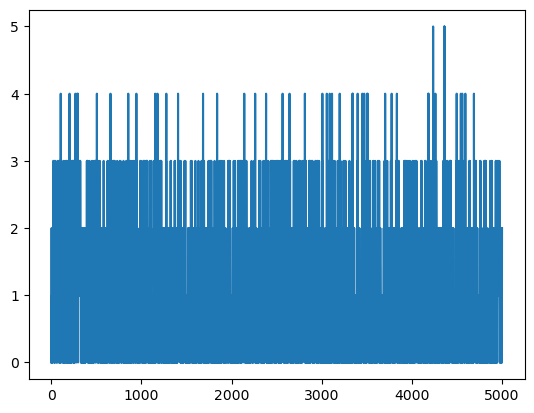

In [3]:
plt.figure(figsize = (12, 6))
plt.imshow(Y[0, ...], cmap = 'Greys', aspect = 'auto', vmin = np.quantile(Y, 0.01), vmax = np.quantile(Y, 0.99))
plt.xlabel('time')
plt.ylabel('neuron')
plt.title('Raw activity', fontsize = 25)
plt.xticks([])
plt.yticks([])
plt.show()

# Plot spikes for neuron with highest firing rate
# plt.figure(figsize = (12, 6))
plt.plot(Y[0, np.argmax(np.mean(Y, axis = -1)), :])
plt.show()

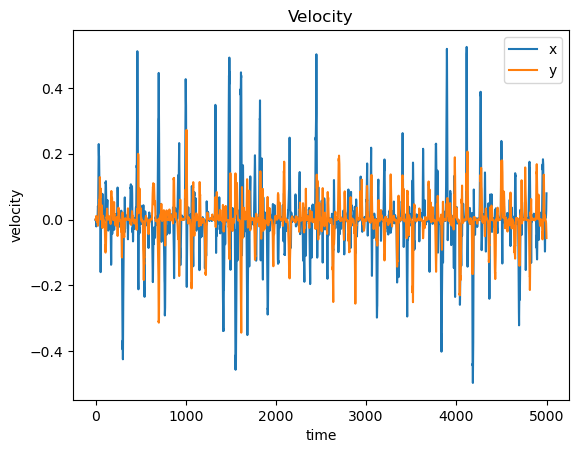

(1, 194, 5000) (5000, 2)


In [3]:
plt.plot(vels[:, 0], label = 'x')
plt.plot(vels[:, 1], label = 'y')
plt.legend()
plt.xlabel('time')
plt.ylabel('velocity')
plt.title('Velocity', fontsize = 12)
plt.show()

print(Y.shape, vels.shape)

In [4]:
link_fn = torch.nn.functional.softplus
# link_fn = torch.exp
lik = Poisson_noise()

# link_fn = lambda x: x
# lik = Negative_binomial_noise(Y=Tensor(Y))

np.random.seed(0)
torch.manual_seed(0)

# suffix = '10'
# z = Tensor(np.load('z_hat' + suffix + '.npy'))[..., start:start+data_len]
# # z = Tensor(np.load('params/z_hat' + suffix + '.npy'))
# print(z.shape)
# A = Tensor(np.load('params/A' + suffix + '.npy'))[None, ...].to(device)
# B = Tensor(np.load('params/B' + suffix + '.npy'))[None, ...].to(device)
# W = np.load('params/W' + suffix + '.npy')
# mu0 = Tensor(np.load('params/mu0' + suffix + '.npy'))[None, ...].to(device)
# Sigma0_half = Tensor(np.load('params/Sigma0_half' + suffix + '.npy'))[None, ...].to(device)

suffix = '_1t'
p = pickle.load(open('new_params/' + suffix + '.pkl', 'rb'))
p.R_half.data = torch.linalg.cholesky(p.R)
# z = Tensor(np.load('new_params/z_hat' + suffix + '.npy'))[..., start:start+data_len]
z = Tensor(np.load('new_params/z_hat' + suffix + '_shifted.npy'))[..., start:start+data_len]
A = p.A.clone()[None, ...].to(device)
B = torch.linalg.cholesky(p.Q)[None, ...].to(device)
mu0 = p.mu0.clone()[None, ...].to(device)
Sigma0_half = torch.linalg.cholesky(p.Sigma0)[None, ...].to(device)
W = p.W.detach().cpu().numpy()
print(z.shape, A.shape, B.shape, mu0.shape, Sigma0_half.shape, W.shape)


def is_lower_triangular(tensor):
    return torch.all(tensor.triu(1) == 0)
print(is_lower_triangular(Tensor(Sigma0_half)))
print(is_lower_triangular(Tensor(B)))

# print(B - torch.linalg.cholesky(B @ B.transpose(-1,-2)))
def convert_to_trials(_Y, _z, _v, t):
    print(_Y.shape[-1], t)
    assert _Y.shape[-1] % t == 0
    N = _Y.shape[1]
    b = _z.shape[1]
    b_v = _v.shape[1]
    ntrials = _Y.shape[-1] // t
    # Y = _Y.reshape(ntrials, -1, t)
    # v = _v.reshape(ntrials, -1, t)
    Y = _Y.transpose(1,0,2).reshape(N,ntrials,-1).transpose(1,0,2)
    z = _z.permute(1,0,2).reshape(b,ntrials,-1).permute(1,0,2)
    v = _v.permute(1,0,2).reshape(b_v,ntrials,-1).permute(1,0,2)
    return Y, z, v

print(Y.shape, z.shape)
train_len = 4000
trial_len = 100
Y_train = Y[..., :train_len]
z_train = z[..., :train_len]
v_train = v[..., :train_len]
Y_test = Y[..., train_len:]
z_test = z[..., train_len:]
v_test = v[..., train_len:]
Y_train, z_train, v_train = convert_to_trials(Y_train, z_train, v_train, trial_len)
# Y_test, z_test, v_test = convert_to_trials(Y_test, z_test, v_test, trial_len)
print(Y_train.shape, z_train.shape, v_train.shape)
# print(Y_test.shape, z_test.shape, v_test.shape)
p.v = v_train.to(device)



# _W = torch.randn(1, z_train.shape[1], z_train.shape[1]).to(device) / np.sqrt(z_train.shape[1])
# _C = torch.randn(1, Y_train.shape[1], z_train.shape[1]).to(device) / np.sqrt(z_train.shape[1])


# model = LDS(z_train, Tensor(Y_train), lik, link_fn=link_fn, A=A, B=B, mu0=mu0, Sigma0_half=Sigma0_half, trained_z=True, single_sigma_x=True, d=-0.8766, fixed_d=True)
# # train_params = {'batch_size': 10, 'n_mc': 50, 'lrate': 5e-2, 'max_steps': 1001, 'step_size': 1000}
# train_params = {'batch_size': None, 'n_mc': 100, 'lrate': 5e-2, 'max_steps': 1001, 'step_size': 1000}
# model.train_supervised_model(model.training_params(**train_params))
# model.plot_LL()


torch.Size([1, 10, 5000]) torch.Size([1, 10, 10]) torch.Size([1, 10, 10]) torch.Size([1, 10]) torch.Size([1, 10, 10]) (2, 10)
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
(1, 194, 5000) torch.Size([1, 10, 5000])
4000 100
(40, 194, 100) torch.Size([40, 10, 100]) torch.Size([40, 2, 100])


step 0 LL -57.35770088711948
step 1 LL -57.42452676688584
step 2 LL -57.34540565846855
step 3 LL -57.326779693849375
step 4 LL -57.34566045240363
step 5 LL -57.33581285412534
step 6 LL -57.31075392474216
step 7 LL -57.29754544926374
step 8 LL -57.29916729504094
step 9 LL -57.30120523571696
step 10 LL -57.29560146701045
step 11 LL -57.284992632816035
step 12 LL -57.27585630321149
step 13 LL -57.27140523222721
step 14 LL -57.269792665322484
step 15 LL -57.26788869347186
step 16 LL -57.26407652663329
step 17 LL -57.25897497690811
step 18 LL -57.253882999316545
step 19 LL -57.249716670295896
step 20 LL -57.24636304244615
step 21 LL -57.24358792733785
step 22 LL -57.24077094793325
step 23 LL -57.23776555290357
step 24 LL -57.23471094578774
step 25 LL -57.23161768391765
step 26 LL -57.22853598318162
step 27 LL -57.225575482887685
step 28 LL -57.2227439439752
step 29 LL -57.22005058089188
step 30 LL -57.217520024107095
step 31 LL -57.21501183579004
step 32 LL -57.2125854857961
step 33 LL -57.

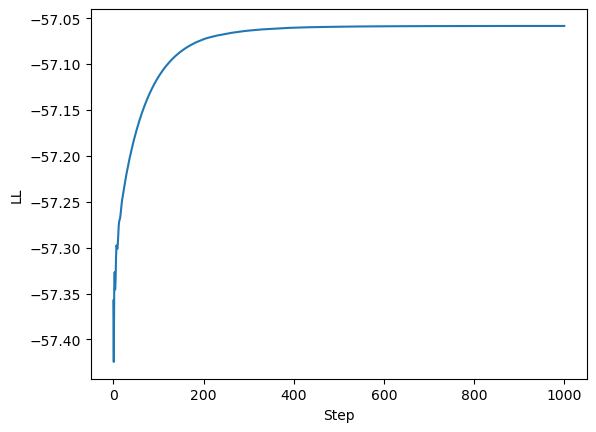

In [9]:
# x_dim = Y.shape[1]
# C = torch.eye(x_dim)[None, ...].to(device)
# _W = torch.randn(1, x_dim, z_train.shape[1]).to(device) / np.sqrt(z_train.shape[1])
# model = LDS(z_train, Tensor(Y_train), lik, link_fn=link_fn, A=A, B=B, mu0=mu0, Sigma0_half=Sigma0_half, trained_z=True, fixed_d=False, single_sigma_x=False, C=C, x_dim=x_dim, full_R=True, W=_W.clone(), analytical_init=True)
# model.C.requires_grad = False
x_dim = 500
model = LDS(z_train, Tensor(Y_train), lik, link_fn=link_fn, A=A, B=B, mu0=mu0, Sigma0_half=Sigma0_half, trained_z=True, fixed_d=False, single_sigma_x=False, x_dim=x_dim, full_R=True)
# model.log_sigma_x.data = torch.log(torch.ones(x_dim)).to(device)
train_params = {'batch_size': None, 'n_mc': 100, 'lrate': 1e-2, 'max_steps': 1001, 'step_size': 200}
# train_params = {'batch_size': None, 'n_mc': 100, 'lrate': 1e-3, 'max_steps': 1001, 'step_size': 1000}
model.train_supervised_model(model.training_params(**train_params))
model.plot_LL()

In [16]:
# dill.dump(model, open('bgpfa_models/new.pkl', 'wb'))
# model = dill.load(open('bgpfa_models/new.pkl', 'rb'))
model = rec_model.gen_model

tensor([[-3.4821e-01,  2.2706e-01,  6.6309e-01, -2.2419e-01, -2.5989e-01,
         -4.4334e-01,  2.0498e-01,  4.6569e-01,  1.9144e-01, -5.1847e-02,
          9.6188e-01,  1.1280e+00, -2.7570e-01, -2.7016e-01,  1.9731e-01,
          4.5021e-01, -1.9404e-01, -7.2415e-02, -2.1776e-01, -5.9035e-02,
         -4.7871e-01,  1.6183e-02,  3.3312e-01, -1.5198e-01, -6.1905e-01,
         -3.3056e-01, -3.2318e-01, -3.7337e-02,  2.8279e-01, -3.1278e-01,
          2.4222e-01, -9.2261e-01,  8.3026e-02,  1.1683e-01, -6.5898e-01,
          1.1211e+00, -8.4469e-01,  7.7299e-01,  2.2839e-01,  7.4805e-01,
          5.0786e-01, -5.1484e-01,  1.0276e-01,  1.2569e+00, -1.4919e-02,
          3.7374e-01, -2.7177e-01,  2.1529e-01, -1.3399e-01,  3.5562e-01,
         -4.6434e-01,  4.2745e-01, -2.7537e-01,  3.2458e-01,  8.4493e-01,
          6.6946e-01, -8.0970e-01,  1.9317e-01, -3.6679e-01,  3.0422e-01,
          8.9732e-02, -8.2594e-01, -2.1450e-01,  2.2711e-01, -4.8367e-01,
         -2.6883e-01,  1.1335e-01,  1.

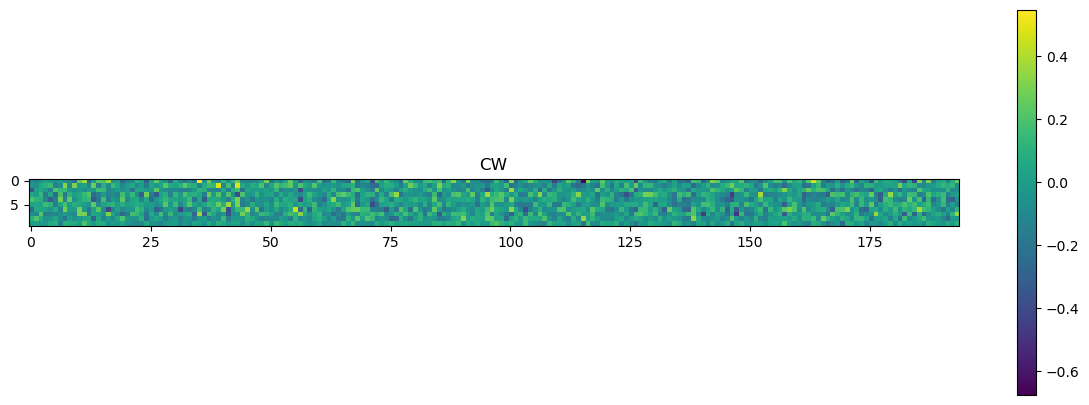

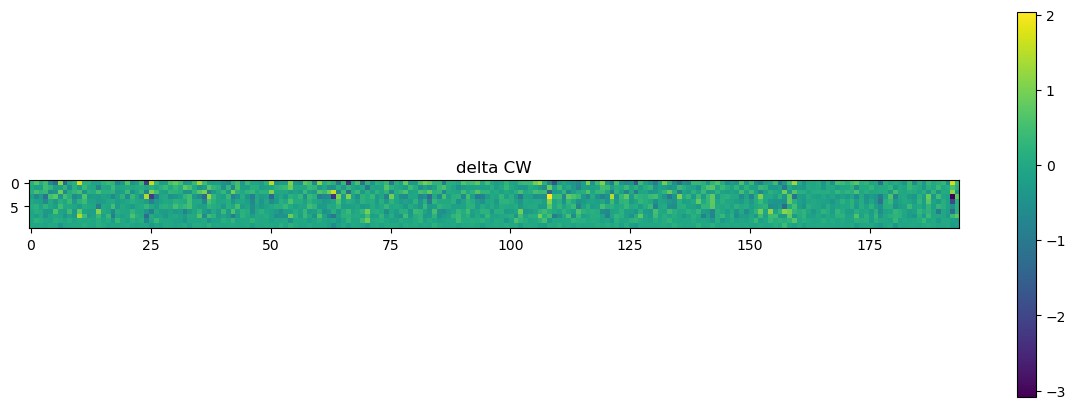

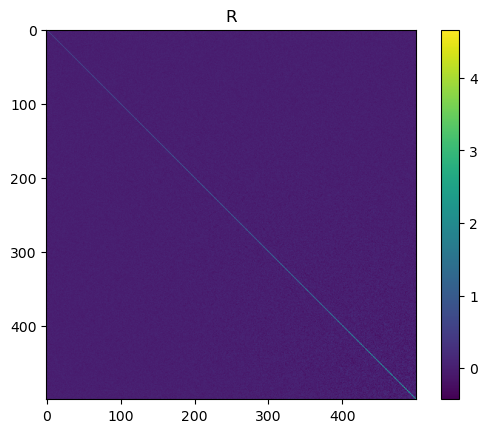

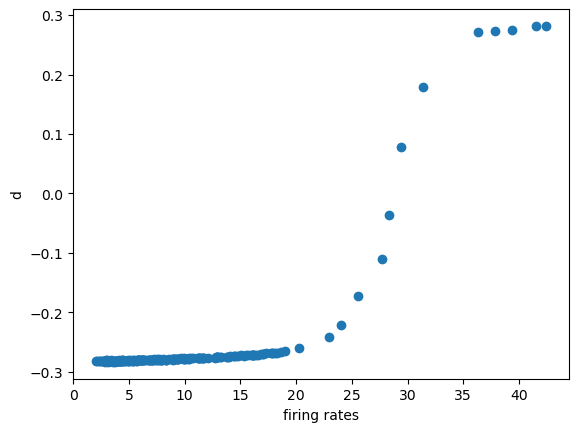

ValueError: x and y must have same first dimension, but have shapes (194,) and (500,)

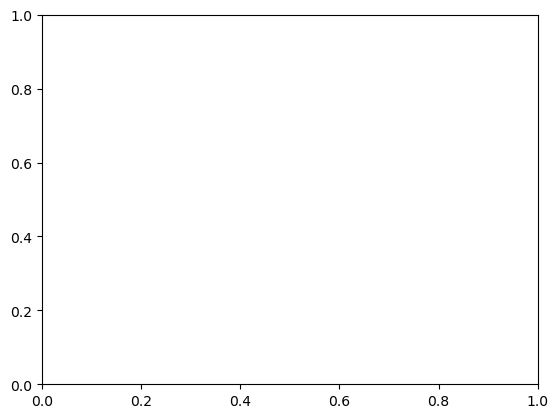

In [8]:
# for name, prm in model.named_parameters():
#     print(f'Name: {name} - Shape: {prm.shape} - Parameter: {prm}')
# print('sigma_x', model.sigma_x)
# print('d', model.d)
print((model.C @ model.W).sum(axis=-1))
# print(torch.diag(model.Q[0]))
# print(torch.diag(model.Sigma0[0]))

# print(torch.linalg.eigvals(model.A))

# # print(model.lik.total_count)

# plt.imshow(model.W[0].detach().cpu().numpy())
# plt.colorbar()
# plt.title('W')
# plt.show()

# plt.imshow(model.W[0].detach().cpu().numpy() - _W[0].detach().cpu().numpy())
# plt.colorbar()
# plt.title('delta W')
# plt.show()

# plt.figure(figsize=(15, 5))  # Adjust as needed
# plt.imshow(model.C[0].detach().cpu().numpy().T)
# plt.colorbar()
# plt.title('C')
# plt.show()


plt.figure(figsize=(15, 5))  # Adjust as needed
plt.imshow((model.C @ model.W)[0].detach().cpu().numpy().T)
plt.colorbar()
plt.title('CW')
plt.show()

gen_model_orig = dill.load(open('bgpfa_models/new.pkl', 'rb'))
plt.figure(figsize=(15, 5))  # Adjust as needed
plt.imshow(((gen_model_orig.C @ gen_model_orig.W) - (model.C @ model.W)).detach().cpu().numpy().T)
plt.colorbar()
plt.title('delta CW')
plt.show()

plt.imshow(model.R.squeeze(0).detach().cpu().numpy(), label='sigma_x')
plt.colorbar()
plt.title('R')
# # plot neuron firing rates
# plt.plot(_Y_train.mean(dim=(0,2))/T_trial, 'x', label='firing rates')
# plt.legend()
plt.show()

plt.plot(Y_train.mean(axis=(0,2))/0.025, model.d.detach().cpu().numpy(), 'o')
plt.xlabel('firing rates')
plt.ylabel('d')
plt.show()
# print(model.lik.sigma, 'sigma')
# print(min(model.sigma_x), max(model.sigma_x), 'sigma_x')

plt.plot(Y_train.mean(axis=(0,2))/0.025, torch.diag(model.R.squeeze()).detach().cpu().numpy(), 'o')
# plt.plot(_Y_train.mean(dim=(0,2))/T_trial, torch.square(torch.exp(m.log_sigma_x)).detach().cpu().numpy(), 'o')
plt.xlabel('firing rates')
plt.ylabel('var_x')
plt.show()




# plt.hist(model.d.detach().cpu().numpy(), bins=30)
# plt.title('d')
# plt.show()
# plt.hist(model.sigma_x.detach().cpu().numpy(), bins=30)
# plt.title('sigma_x')
# plt.show()

In [4]:
# model.freeze_params()
# dill.dump(model, open('bgpfa_models/new.pkl', 'wb'))
rec_model = dill.load(open('bgpfa_models/new_rec.pkl', 'rb'))

torch.Size([3, 1, 10, 100])


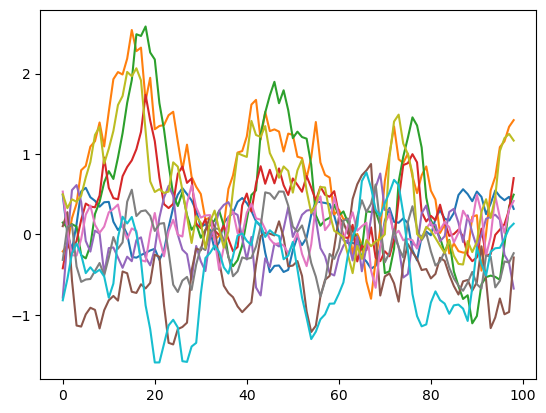

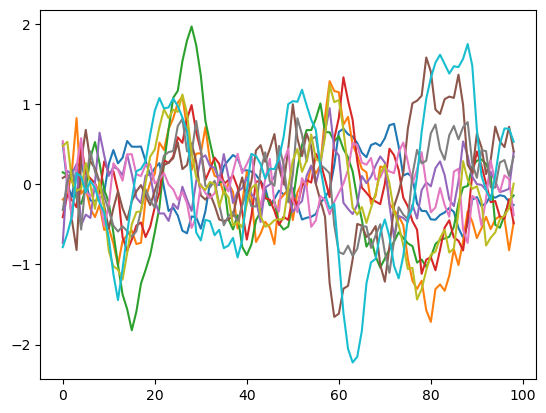

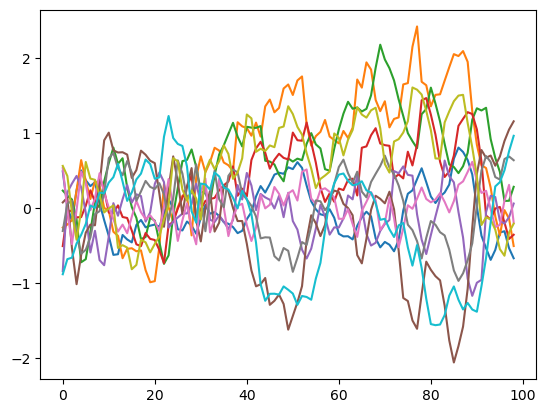

In [38]:
z_samps = model.sample_z(3, 1)
print(z_samps.shape)
stop = -1
for i in range(len(z_samps)):
    for j in range(10):
        plt.plot(z_samps[i,0,j, :stop].detach().cpu().numpy())
    plt.show()
    # C_prime = p.W
    # v_samps = C_prime @ z_samps[i, ...] 
    # for j in range(2):
    #     plt.plot(v_samps[0,j,:stop].detach().cpu().numpy())
    plt.show()

In [11]:
# pickle.dump(model, open('bgpfa_models/first.pkl', 'wb'))
# model = pickle.load(open('bgpfa_models/first.pkl', 'rb'))

In [11]:
model.freeze_params()
model.W.requires_grad = True
model.d.requires_grad = True
model.C.requires_grad = True
# model.log_sigma_x.requires_grad = True
model.R_half.requires_grad = True

# p.v = p.v[:40, ...]
# print(p.v.shape)
# print(model.z.shape)
# p.R_half.data = torch.linalg.cholesky(p.R)

class MyRNNModel(Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MyRNNModel, self).__init__()
        self.rnn = torch.nn.RNN(input_size, hidden_size, batch_first=True, bidirectional=True, num_layers=2)
        self.fc = torch.nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out)
        return out

neural_net = MyRNNModel(model.N, 100, model.x_dim)

rec_model = RecognitionModel(model, rnn=True, neural_net=neural_net, gen_model_fixed=False, preprocessor=p)
train_params = {'batch_size': None, 'step_size': 100, 'lrate': 1e-3, 'max_steps': 201, 'n_mc_x': 10, 'n_mc_z': 10, 'batch_mc_z': 10}
rec_model.train_recognition_model(rec_model.training_params(**train_params))
rec_model.plot_LL()

# rec_model = dill.load(open('bgpfa_models/first_rec.pkl', 'rb'))

step 0 LL -101.2382 Entropy -3.6676 ln p(y|z) -0.5634 ln p(z) -1533.8814 ln p(v|z) -2178.9482
step 1 LL -238.0359 Entropy -3.6679 ln p(y|z) -0.5631 ln p(z) -4234.7825 ln p(v|z) -2080.6463
step 2 LL -59.6266 Entropy -3.6689 ln p(y|z) -0.5640 ln p(z) -692.1031 ln p(v|z) -2309.8401
step 3 LL -61.8270 Entropy -3.6690 ln p(y|z) -0.5621 ln p(z) -740.7958 ln p(v|z) -2282.1993
step 4 LL -47.4930 Entropy -3.6687 ln p(y|z) -0.5612 ln p(z) -487.8020 ln p(v|z) -2142.5162
step 5 LL -42.5267 Entropy -3.6681 ln p(y|z) -0.5606 ln p(z) -401.2683 ln p(v|z) -2088.5545
step 6 LL -40.6921 Entropy -3.6681 ln p(y|z) -0.5605 ln p(z) -362.6784 ln p(v|z) -2101.7267
step 7 LL -36.9375 Entropy -3.6681 ln p(y|z) -0.5603 ln p(z) -302.9357 ln p(v|z) -2032.5075
step 8 LL -36.4195 Entropy -3.6681 ln p(y|z) -0.5602 ln p(z) -288.5623 ln p(v|z) -2053.6249
step 9 LL -37.3200 Entropy -3.6683 ln p(y|z) -0.5602 ln p(z) -282.0710 ln p(v|z) -2174.3274
step 10 LL -34.3748 Entropy -3.6685 ln p(y|z) -0.5599 ln p(z) -230.3597 ln p

KeyboardInterrupt: 

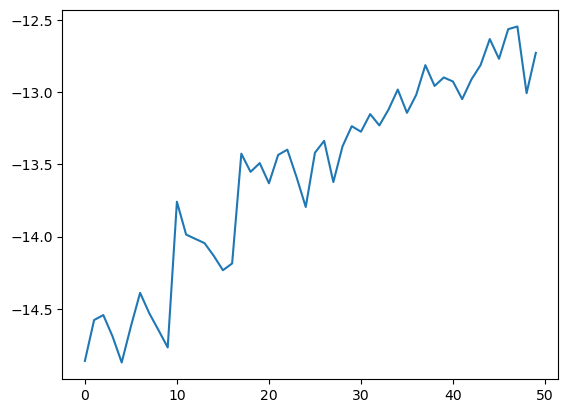

In [5]:
# rec_model = dill.load(open('bgpfa_models/new_rec.pkl', 'rb'))
# rec_model = dill.load(open('bgpfa_models/new_change_p_rec.pkl', 'rb'))
rec_model = dill.load(open('bgpfa_models/shifted_rec.pkl', 'rb'))
plt.plot(rec_model.LLs[50:100])
plt.show()

torch.Size([40, 194, 100])


/home/ayush/anaconda3/lib/python3.11/site-packages/torch/nn/modules/rnn.py:812: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


(1, 10, 4000)


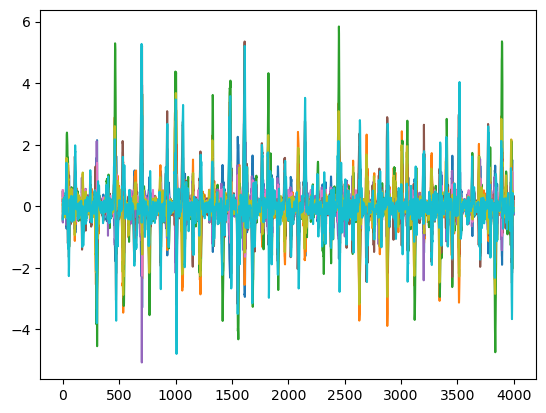

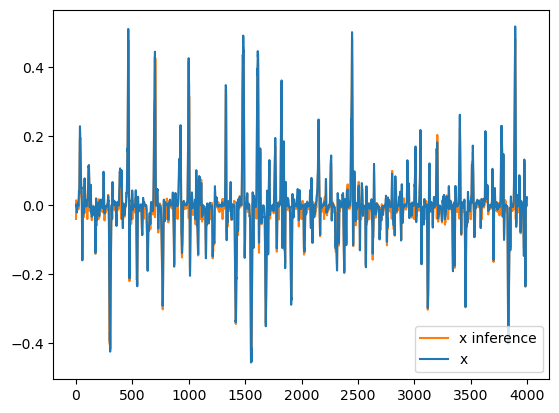

0.948250769904748
0.919120100669775


In [6]:
print(rec_model.gen_model.Y.shape)
z = rec_model.test_z(rec_model.gen_model.Y)

# Y_test = Y[..., train_len:]
# z = rec_model.test_z(Tensor(Y_test).to(device))

z = z.detach().cpu().numpy()
z = z.transpose(1,0,2).reshape(10, 1, -1).transpose(1,0,2)
print(z.shape)
plt.plot(z[0,:,:].T)
plt.show()
# z = z.reshape(1,-1,1000)
# W = np.load('params/W' + suffix + '.npy')

# W = pickle.load(open('new_params/_10t.pkl', 'rb')).W.detach().cpu().numpy()
W = p.W.detach().cpu().numpy()
# W = rec_model.preprocessor.W.detach().cpu().numpy()
z = W @ z

train_len = 4000
# _vels = vels[train_len:]
_vels = vels[:train_len]

start = 0
stop = 4000
plt.plot(z[0,0,start:stop], label = 'x inference', color = 'C1')
# plt.plot(z[0,1,start:stop], label = 'y inference', color = 'C1')
plt.plot(_vels[start:stop, 0], label = 'x', color = 'C0')
# plt.plot(_vels[start:stop, 1], label = 'y', color = 'C0')x
plt.legend()
plt.show()

# print R^2 for x and y decoding using sklearn
print(r2_score(_vels[:, 0], z[0,0,:]))
print(r2_score(_vels[:, 1], z[0,1,:]))

/home/ayush/anaconda3/lib/python3.11/site-packages/torch/nn/modules/rnn.py:812: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


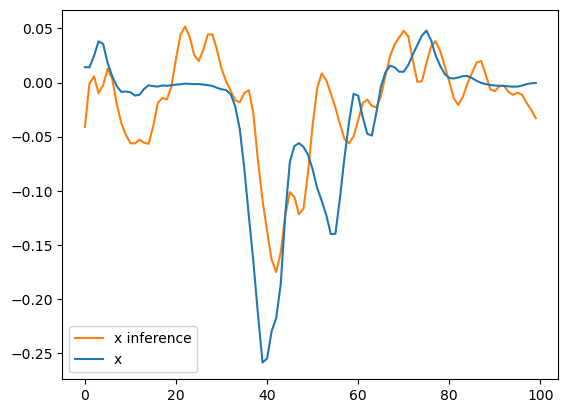

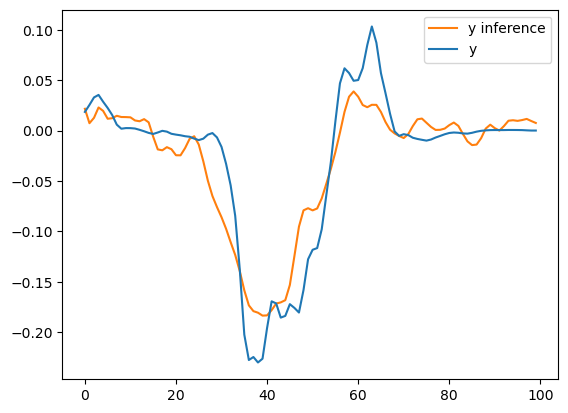

0.5990712644777876 0.7095347111169319 0.6543029877973597


In [8]:
z_test_inferred = rec_model.test_z(Tensor(Y_test).to(device))
z_test_inferred = z_test_inferred.detach().cpu().numpy()
v_test_inferred = W @ z_test_inferred
start = 0
stop = 100
plt.plot(v_test_inferred[0,0,start:stop], label = 'x inference', color = 'C1')
plt.plot(v_test[0,0,start:stop], label = 'x', color = 'C0')
plt.legend()
plt.show()
plt.plot(v_test_inferred[0,1,start:stop], label = 'y inference', color = 'C1')
plt.plot(v_test[0,1,start:stop], label = 'y', color = 'C0')
plt.legend()
plt.show()

x_r2 = r2_score(v_test[0,0,:], v_test_inferred[0,0,:])
y_r2 = r2_score(v_test[0,1,:], v_test_inferred[0,1,:])
print(x_r2, y_r2, (x_r2 + y_r2)/2)

In [23]:
# dill.dump(rec_model, open('bgpfa_models/first_rec.pkl', 'wb'))